# Exploring Dynamical Isometry

Dynamical Isometry is a desirable property of neural network weight initialisations which is known to improve training efficiency.

This work refers to the papers:

- [Resurrecting the sigmoid in deep learning throughdynamical isometry: theory and practice](https://arxiv.org/pdf/1711.04735.pdf)

In [1]:
%cd ..

/work


In [2]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

## To start: a basic neural network for MNIST

We'll start with a basic neural network with sigmoid activations.

In [3]:
class Linear(nn.Module):
    "An affine mapping"
    
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Parameter(torch.randn(out_features, in_features))
        self.b = nn.Parameter(torch.randn(out_features))
        
    def forward(self, x):
        return x @ self.W.T + self.b

class LinearSigmoid(Linear):
    
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        self.W = nn.Parameter(self.W / np.sqrt(in_features))
        self.b = nn.Parameter(torch.zeros_like(self.b))
    
    def forward(self, x):
        return torch.sigmoid(super().forward(x))


In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [6]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [8]:
print(train_data.targets.size())

torch.Size([60000])


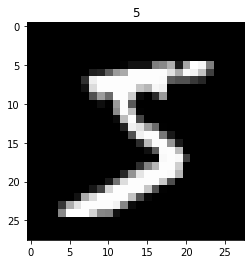

In [9]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

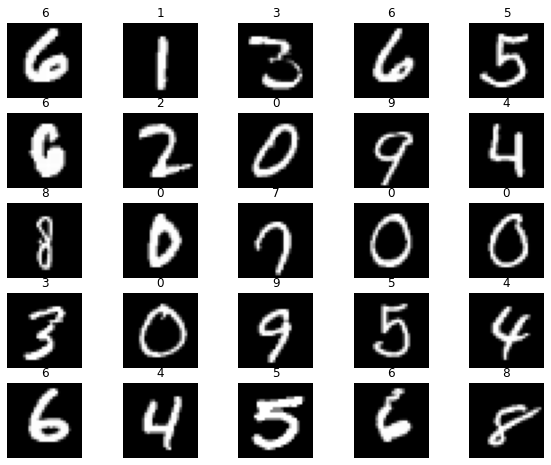

In [10]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [11]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=0),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1f160a8e10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f2023522828>}

In [12]:
linear_sigmoid = LinearSigmoid(28 * 28, 10)
print(linear_sigmoid)

LinearSigmoid()


In [13]:
from torch import optim
optimizer = optim.Adam(linear_sigmoid.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [14]:
from torch.autograd import Variable
num_epochs = 10

def train(num_epochs, model, loaders):
    
    # Train the model
    total_step = len(loaders['train'])
    loss_func = nn.CrossEntropyLoss()   
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).reshape(100, 28 * 28)  # batch x
            b_y = Variable(labels)                        # batch y
            output = linear_sigmoid(b_x)
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step
            optimizer.zero_grad()
            
            # backpropagation, compute gradients 
            loss.backward()  # apply gradients             
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item()}',
                     end = '')

train(num_epochs, linear_sigmoid, loaders)

Epoch [10/10], Step [600/600], Loss: 1.5111558437347412

In [15]:
def test():
    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.reshape(100, 28 * 28)
            test_output = linear_sigmoid(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print(f'Test Accuracy of the model on the 10,000 test images: {accuracy * 100:.1f}%')

test()

Test Accuracy of the model on the 10,000 test images: 87.0%
